### Automated anomaly detection using PyOD and Auto-Sklearn
This notebook incorporates anomaly detection algorithms from PyOD into Auto-Sklearn. The following steps are followed:
- Auto-Sklearn is extended to incorporate PyOD algorithms
- Anomaly detection dataset(s) are imported and pre-processed
- Dataset is passed to Auto-Sklearn automl object for automated modeling and prediction
- Results and stats are obtained and analyzed

In [13]:
# Imports
import os, sys
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from datetime import timedelta as td
import sklearn.metrics
from sklearn.model_selection import train_test_split, PredefinedSplit, StratifiedShuffleSplit
from autosklearn.pipeline.components.classification import add_classifier
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc, average_precision
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import import_dataset, add_pyod_models_to_pipeline, balanced_split, get_metric_result
# Add models to Auto-Sklearn
add_pyod_models_to_pipeline()

In [2]:
# Classifiers to be included
classifiers = [
    #'ABODClassifier',
    #'CBLOFClassifier',
    'COPODClassifier',
    #'ECODClassifier',
    #'HBOSClassifier',
    #'IForestClassifier',
    'KNNClassifier',
    #'LMDDClassifier',
    'LOFClassifier',
    #'MCDClassifier',
    #'OCSVMClassifier', # includes log-scale float hyperparam
    #'PCAClassifier',
    #'RODClassifier',
    #'SOSClassifier' # includes log-scale float hyperparam
]

In [3]:
# Datasets to be included
datasets = {
    'cardio_02': '../../data/Cardiotocography_withoutdupl_norm_02_v10.arff',
    'cardio_05': '../../data/Cardiotocography_withoutdupl_norm_05_v10.arff',
    'cardio_10': '../../data/Cardiotocography_withoutdupl_norm_10_v10.arff',
    'cardio_20': '../../data/Cardiotocography_withoutdupl_norm_20_v10.arff',
    'cardio_22': '../../data/Cardiotocography_withoutdupl_norm_22.arff'
}

In [7]:
# Sampling size
N = 5000
# Budget
total_budget = 300 # in seconds
per_run_budget = 30 # in seconds

# Performance dicts
valid_performance = {}
test_performance = {}

# Loop over datasets
for d_name, d_file in datasets.items():
    # Import DataFrame
    df = import_dataset(d_file)
    print('Dataset: {}, shape: {}'.format(d_name, df.shape))
    # Subsample
    if(len(df) > N):
        df = df.sample(n=N)
    # Extract X, y
    X  = df.iloc[:, :-1]
    y = df['outlier']
    # Split to train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

    # choose validation set
    validation_type = 'stratified' # balanced vs stratified

    # Method 1 - Balanced split
    #selected_indices = balanced_split(y_train)
    #resampling_strategy = PredefinedSplit(test_fold=selected_indices)

    # Method 2 - Stratified Shuffle Split
    resampling_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

    # Build autosklearn classifier
    automl = AutoSklearnClassifier(
        include = {
          'classifier': classifiers,
          'feature_preprocessor': ["no_preprocessing"],
        },
        exclude = None,
        metric = roc_auc,
        scoring_functions = [roc_auc, average_precision],
        time_left_for_this_task = total_budget,
        per_run_time_limit = per_run_budget,
        ensemble_size = 0,
        initial_configurations_via_metalearning = 0,
        resampling_strategy = resampling_strategy,
    )
    # Fit
    print('Fitting..')
    automl.fit(X_train, y_train, X_test, y_test, dataset_name='Cardiotography')

    # Print stats
    print(automl.sprint_statistics())
    #print(get_metric_result(automl.cv_results_).to_string(index=False))
    #print('\n\n')
    # Store performance metrics
    valid_performance[d_name] = automl.performance_over_time_[['Timestamp', 'single_best_optimization_score']]
    test_performance[d_name] = automl.performance_over_time_[['Timestamp', 'single_best_test_score']]

Dataset: cardio_02, shape: (1681, 22)
Fitting..
[WARNING] [2022-03-13 00:49:18,827:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_f9bf05ff-a255-11ec-9485-7d1c88eb7007/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Cardiotography
  Metric: roc_auc
  Best validation score: 0.809496
  Number of target algorithm runs: 62
  Number of successful target algorithm runs: 56
  Number of crashed target algorithm runs: 6
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0

Dataset: cardio_05, shape: (1734, 22)
Fitting..
[WARNING] [2022-03-13 00:54:14,425:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_a9c77108-a256-11ec-9485-7d1c88eb7007/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Cardiotography
  Metric: roc_auc
  Best validation score: 0.881599
  Number of target algorithm runs: 73
 

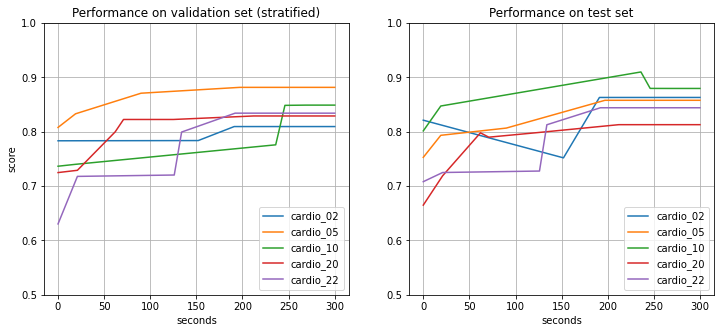

In [12]:
# Figure
fig, (axv, axt) = plt.subplots(1, 2, figsize=(12,5))
#
# Plot validation performance
for d, results in valid_performance.items():
    # exctract series
    xv = (results.Timestamp-results.Timestamp[0]).apply(td.total_seconds)
    yv = results.single_best_optimization_score
    # modify for plotting
    xv.at[xv.shape[0]] = total_budget
    yv.at[yv.shape[0]] = yv.at[yv.shape[0]-1]
    axv.plot(xv, yv)
axv.legend(list(datasets.keys()), loc='lower right')
axv.set_ylim([0.5, 1.])
axv.set_xlabel('seconds')
axv.set_ylabel('score')
axv.set_title('Performance on validation set ({})'.format(validation_type))
axv.grid()
#
# Plot test set performance
for d, results in test_performance.items():
    # exctract series
    xt = (results.Timestamp-results.Timestamp[0]).apply(td.total_seconds)
    yt = results.single_best_test_score
    # modify plotting
    xt.at[xt.shape[0]] = total_budget
    yt.at[yt.shape[0]] = yt.at[yt.shape[0]-1]
    axt.plot(xt, yt)
axt.legend(list(datasets.keys()), loc='lower right')
axt.set_ylim([0.5, 1.])
axt.set_xlabel('seconds')
#axt.set_ylabel('score')
axt.set_title('Performance on test set')
axt.grid()